<br/>
$$ \huge{\underline{\textbf{ 1-Layer Neural Network }}} $$
<br/>

Contents:
* [Introduction](#Introduction)
* [Load and Explore Data](#Load-and-Explore-Data)
* [Preprocess](#Preprocess)
* [Neural Network](#Neural-Network)
* [Train Classifier](#Train-Classifier)

# Introduction

This notebook presents simplest possible 1-layer neural network trained with backpropagation.

**Dataset**

We will use graduate school admissions data ([https://stats.idre.ucla.edu/stat/data/binary.csv]()). Each row is one student. Columns are as follows:
* admit - was student admitted or not? This is our target we will try to predict
* gre - student GRE score
* gpa - student GPA
* rank - prestige of undergrad school, 1 is highest, 4 is lowest

**Model**

* one layer: fully connected with sigmoid activation
* loss: MSE
* optimizer: vanilla SGD

**Dependencies**
* numpy, matplotlib - neural net and backprop
* pandas - load data

# Load and Explore Data

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Loda data with pandas

In [2]:
df = pd.read_csv('college_admissions.csv')

Show first couple rows. First column is index, added automatically by pandas.

In [3]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Show some more information about dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


Plot data, each rank separately

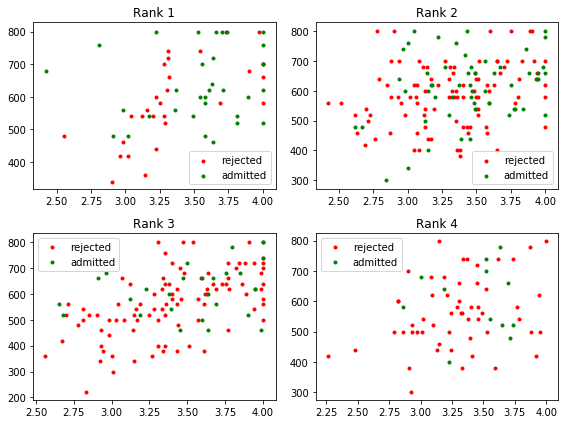

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8,6])
axes = axes.flatten()
for i, rank in enumerate([1,2,3,4]):
    # pick not-admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==0)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='red', marker='.', label='rejected')
    # pick admitted students with given rank
    tmp = df.loc[(df['rank']==rank) & (df['admit']==1)]
    axes[i].scatter(tmp['gpa'], tmp['gre'], color='green', marker='.', label='admitted')
    axes[i].set_title('Rank '+str(rank))
    axes[i].legend()
fig.tight_layout()

And plot scatter matrix, just for fun

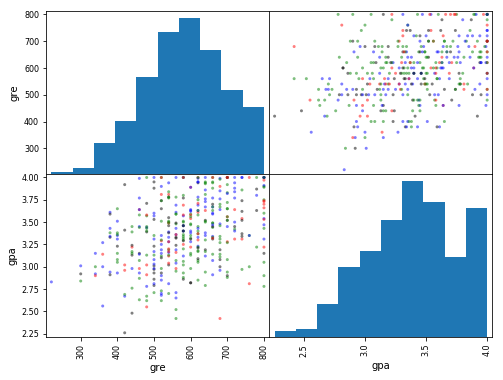

In [6]:
cmap = {1: 'red', 2:'green', 3:'blue', 4:'black'}
colors = df['rank'].apply(lambda cc:cmap[cc])
pd.plotting.scatter_matrix(df[['gre', 'gpa']], c=colors, figsize=[8,6]);

# Preprocess

Code below does following things:
* convert _rank_ column into one-hot encoded features
* normalize _gre_ and _gpa_ columns to zero mean and unit standard deviation
* splits of 20% of data as test set
* splits into input features (gre, gpa, one-hot-rank) and targets (admit)
* convert into numpy
* assert shapes are ok

In [7]:
# Create dummies
temp = pd.get_dummies(df['rank'], prefix='rank')
data = pd.concat([df, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 20% of the data for testing
np.random.seed(0)
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
features_train = data.drop('admit', axis=1)
targets_train =  data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

# Convert to numpy
x_train = features_train.values            # features train set (numpy)
y_train = targets_train.values[:,None]     # targets train set (numpy)
x_test = features_test.values              # features validation set (numpy)
y_test = targets_test.values[:,None]       # targets valudation set (numpy)

# Assert shapes came right way around
assert x_train.shape == (360, 6)
assert y_train.shape == (360, 1)
assert x_test.shape == (40, 6)
assert y_test.shape == (40, 1)

# Neural Network

By convention, we will denote:
* $x$ as matrix of input features, where rows are separate training examples in mini-batch and columns are features
* $y$ as column vector of targets (admitted or not)
* $\hat{y}$ as neural network estimates
* $L$ as scalar-output loss function

First we need sigmoid transfer function and its derivative ([proof](https://en.wikipedia.org/wiki/Logistic_function#Derivative))
$$ S(x) = \frac{1}{1+\epsilon^{-x}} \quad\quad S'(x) = S(x)(1-S(x)) $$

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

Forward pass is pretty simple
$$ \hat{y} = S(xW) $$

In [9]:
def fwd(x, W):
    assert x.ndim == 2; assert W.ndim == 2

    z = x @ W                                   # linear combination
    y_hat = sigmoid(z)                          # transfer function
    
    assert z.ndim == 2; assert y_hat.ndim == 2
    return y_hat

Loss function
$$ L(x,y) = \frac{1}{2n}(y-\hat{y})^2 \quad\quad\quad \text{where $n$ is length of mini-batch} $$

In [10]:
def loss(x, y, W):
    assert x.ndim == 2
    assert y.ndim == 2
    assert W.ndim == 2
    
    y_hat = sigmoid(x @ W)                 # forward pass
    result = .5 * np.mean((y-y_hat)**2)    # no inner sum becouse single output
    
    assert y_hat.shape[1] == 1
    return result

Backward pass

$$ \frac{\partial{L}}{\partial{W}} = \frac{1}{n}x^T \big[ -(y-\hat{y}) \odot S'(x) \big] \quad\quad\quad \text{ where $\odot$ is element-wise product} $$

If you are wondering how above came about, then good resources are [here](http://cs231n.stanford.edu/handouts/linear-backprop.pdf) and [here](http://cs231n.stanford.edu/handouts/derivatives.pdf), both taken from famous cs231n course.

In [11]:
def backprop(x, y, W, lr):
    assert x.ndim == 2; assert y.ndim == 2; assert W.ndim == 2
    
    # Forward pass
    z = x @ W
    y_hat = sigmoid(z)
    
    # Backward pass
    ro = -(y-y_hat) * sigmoid_deriv(z)
    del_W = (x.T @ ro) / len(x)
    
    assert del_W.ndim == 2
    return del_W

Numerical gradient check

In [12]:
def ngrad(x, y, W):
    """Check gradient numerically"""
    eps = 1e-4
    del_W = np.zeros_like(W)    
    for r in range(W.shape[0]):
        for c in range(W.shape[1]):
            W_min = W.copy()
            W_pls = W.copy()
            
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            l_pls = loss(x, y, W_pls)
            l_min = loss(x, y, W_min)

            del_W[r, c] = (l_pls - l_min) / (eps * 2)
    return del_W

# Train Classifier

Initialize neural net

In [13]:
np.random.seed(0)  # for reproducibility

n_inputs = x_train.shape[1]
n_outputs = y_train.shape[1]

W = np.random.normal(scale=n_inputs**-.5, size=[n_inputs, n_outputs])  # Xavier init

Hyperparameters

In [14]:
nb_epochs = 2000
lr = 0.1

Main train loop

In [15]:
# Accumulate statistics during training (for plotting)
trace_loss_train = []
trace_loss_test = []
trace_acc_test = []

for e in range(nb_epochs):
    
    # Backprop
    dW = backprop(x_train, y_train, W, lr)
    W += -lr * dW
    
    # Train loss
    loss_train = loss(x_train, y_train, W)
    trace_loss_train.append(loss_train)        
    
    # if e % (nb_epochs / 10) == 0:
    loss_test = loss(x_test, y_test, W)
    trace_loss_test.append(loss_test)
    
    # Predictions and Accuracy
    predictions = fwd(x_test, W)
    predictions = predictions > 0.5
    acc_test = np.mean(predictions == y_test)
    trace_acc_test.append(acc_test)

    if e % (nb_epochs / 10) == 0:
        print('loss {0}, tacc {1:.3f}'.format(loss_train, acc_test))

loss 0.15224777536275844, tacc 0.475
loss 0.13015955315177377, tacc 0.475
loss 0.11435294270610373, tacc 0.500
loss 0.10585677810621827, tacc 0.600
loss 0.10191394554520483, tacc 0.675
loss 0.1000000143239566, tacc 0.700
loss 0.09898677097344712, tacc 0.725
loss 0.0984065319217976, tacc 0.750
loss 0.0980521765593448, tacc 0.750
loss 0.09782432184510809, tacc 0.750


Plot learning curve

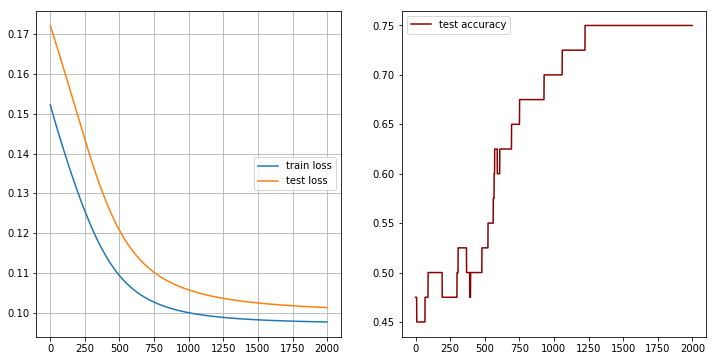

In [16]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=[12,6])
ax1.plot(trace_loss_train, label='train loss')
ax1.plot(trace_loss_test, label='test loss')
ax1.legend(loc='right')
ax1.grid()
ax2.plot(trace_acc_test, color='darkred', label='test accuracy')
ax2.legend()
plt.show()

__Quick Regression Test__

In [17]:
correct_result = np.array([0.15224777536275844,
                           0.13015955315177377,
                           0.11435294270610373,
                           0.10585677810621827,
                           0.10191394554520483,
                           0.1000000143239566,
                           0.09898677097344712,
                           0.0984065319217976,
                           0.0980521765593448,
                           0.09782432184510809])
assert np.alltrue(trace_loss_train[::200] == correct_result)